# Initialization cell

In [55]:
! pip install --upgrade pip
! pip install python-dotenv
! pip install pymorphy2 nltk scikit-learn
! pip install catboost
! pip install xgboost
! pip install -U scikit-learn

In [56]:
import pandas as pd
import numpy as np

import gdown
import os
import json

import matplotlib.pyplot as plt

from dataclasses import dataclass, fields
from typing import List, Optional, Tuple, Dict
from dotenv import load_dotenv

import pymorphy2
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error

from tqdm import tqdm
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

[nltk_data] Downloading package punkt to /home/kitsu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kitsu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preparation cell

In [57]:
ROOT_DIR: str = os.path.dirname(os.path.abspath(os.curdir))
DATASET_PATH: str = f"{ROOT_DIR}/source_data/superset_hr.xlsx"
SKILLS_JSON_PATH: str = f"{ROOT_DIR}/source_data/skills_dictionary.json"
GOOGLE_COLAB_PATH: str = '/content/superset_hr.xlsx'

load_dotenv()
SKILL_DICT_URL = os.environ.get('SKILL_DICT_URL')
DATASET_URL = os.environ.get('DATASET_V2_URL')

if DATASET_URL is None:
    print('>>> .env was not found!', end='\n\n')
    DATASET_URL = input('>>> Provide DATASET url for downloading: ')

    if SKILL_DICT_URL is None: SKILL_DICT_URL = input('>>> Provide JSON url for downloading: ')

In [58]:
def get_skill_dict() -> dict[str: list[int]]:
    try:
        with open(file=SKILLS_JSON_PATH, mode='r') as input_json_file:
            data = json.load(input_json_file)
    except FileNotFoundError:
        print(f"Can't open file from path: {SKILLS_JSON_PATH}", end='\n\n')
        file_name = gdown.download(SKILL_DICT_URL, fuzzy=True)
        os.makedirs(os.path.dirname(SKILLS_JSON_PATH), exist_ok=True)
        os.rename(os.path.abspath(file_name), SKILLS_JSON_PATH)
        print(f'Moved to: {SKILLS_JSON_PATH}', end='\n\n')

        with open(file=SKILLS_JSON_PATH, mode='r') as input_json_file:
            data = json.load(input_json_file)
    return data


def get_original_dataframe() -> pd.DataFrame:
    try:
        df = pd.read_excel(DATASET_PATH)
    except FileNotFoundError:
        try:
            print(f"Can't open file from path: {DATASET_PATH}", end='\n\n')
            df = pd.read_excel(GOOGLE_COLAB_PATH)
        except FileNotFoundError:
            print(f"Can't open file from path: {GOOGLE_COLAB_PATH}", end='\n\n')
            file_name = gdown.download(DATASET_URL, fuzzy=True)
            os.makedirs(os.path.dirname(DATASET_PATH), exist_ok=True)
            os.rename(os.path.abspath(file_name), DATASET_PATH)
            print(f'Moved to: {DATASET_PATH}', end='\n\n')
            df = pd.read_excel(DATASET_PATH)
    finally:
        print('Success!')
        return df

In [59]:
skills_dict = get_skill_dict()

In [60]:
df_original = get_original_dataframe()

Success!


In [61]:
print(df_original.shape)
df_original.sample(3)

(188833, 21)


,id,income_name,name,published_at,created_at,collected_at,url,area__name,salary__currency,salary__gross,...,address__city,schedule__name,grade,employment__name,key_skills__names,languages__names,exchange_rate,salary_from_gross,salary_to_gross,salary_average
68062,95256435,Менеджер по продажам,Key Account Manager,2024-03-22T08:59:20+0300,2024-03-22T08:59:20+0300,2024-03-24 10:34:08.190,https://api.hh.ru/vacancies/95256435?host=hh.ru,Ташкент,UZS,0.0,...,Ташкент,Полный день,Junior (1-3),Полная занятость,"['Negotiation skills', 'Leadership Skills', 'T...",['Русский'],0.00732,82716.0,124074.0,103395.0
32856,94069169,Руководитель проектов,Руководитель проектов,2024-03-01T07:20:32+0300,2024-03-01T07:20:32+0300,2024-03-01 17:20:33.442,https://api.hh.ru/vacancies/94069169?host=hh.ru,Новосибирск,NaN,NaN,...,Новосибирск,Полный день,Junior (1-3),Полная занятость,"['Стрессоустойчивость', 'Гибкий ум', 'Многозад...",[],NaN,NaN,NaN,NaN
143513,98940136,Менеджер по продажам,Менеджер по работе с клиентами,2024-05-30T16:21:25+0300,2024-05-30T16:21:25+0300,2024-06-27 03:07:49.680,https://api.hh.ru/vacancies/98940136?host=hh.ru,Нижний Новгород,RUR,0.0,...,Нижний Новгород,Полный день,Junior (1-3),Полная занятость,[],[],1.00000,50850.0,79100.0,64975.0


# Function & utils cell

In [62]:
def print_df_info(df: pd.DataFrame) -> None:
    print(f"Shape: {df.shape}")
    print('-' * 50)
    display(df.sample(3))
    print('-' * 50)
    display(df.info())

In [81]:
class ClearDataFrameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, save_cols: Optional[List[str]] = None) -> None:
        self.save_cols = save_cols

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'ClearDataFrameTransformer':
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X[self.save_cols].copy()
        df_new.rename(columns={'income_name': 'income__name'}, inplace=True)
        df_new = df_new.dropna(subset=['salary_from_gross', 'salary_to_gross', 'salary_average'], how='all')
        df_new = df_new.dropna(subset=['income__name'])
        df_new = df_new.drop(['salary__currency', 'exchange_rate'], axis=1)
        return df_new


class RenameDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        pass

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'RenameDataTransformer':
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()
        df_new.rename(columns={'income_name': 'income__name'}, inplace=True)
        return df_new


class CreateNewCitiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold: int = 75):
        self.threshold = threshold

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'CreateNewCitiesTransformer':
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()
        cities = df_new['area__name'].unique()
        city_counts = df_new['area__name'].value_counts()
        N_rows = df_new.shape[0]
        ratios = {city: city_counts[city] / N_rows for city in cities}

        answer = []
        all_percentage = 0
        sorted_dict = {k: v for k, v in sorted(ratios.items(), key=lambda item: item[1], reverse=True)}
        for label, pct in sorted_dict.items():
            all_percentage += pct * 100
            if all_percentage < self.threshold:
                answer.append(label)

        df_new.loc[~df_new['area__name'].isin(answer), 'area__name'] = 'Малый город'
        return df_new
    
    
class SelectProfessionsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, prof_list: Optional[List[str]] = None, whitelist: bool = True) -> None:
        self.prof_list = prof_list
        self.whitelist = whitelist

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'SelectProfessionsTransformer':
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()
        if self.whitelist:
            df_new = df_new[df_new['income__name'].isin(self.prof_list)]
        else:
            df_new = df_new[~df_new['income__name'].isin(self.prof_list)]
        return df_new


class FillNaSalaryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, coef_index: int) -> None:
        self.coef_index = coef_index
    
    @staticmethod
    def get_difference_percentiles(df: pd.DataFrame) -> Tuple[float, float, float]:
        filtered_df = df.dropna(subset=['salary_from_gross', 'salary_to_gross']).copy()
        filtered_df.loc[:, 'difference'] = filtered_df['salary_to_gross'] - filtered_df['salary_from_gross']
        condition = filtered_df['difference'] > 0.8 * filtered_df['salary_to_gross']
        filtered_df.loc[condition, ['salary_from_gross', 'difference']] = np.nan

        filtered_df = filtered_df.dropna(subset=['salary_from_gross', 'salary_to_gross'])

        filtered_df = filtered_df[filtered_df['salary_from_gross'] >= 1000]
        filtered_df = filtered_df[filtered_df['salary_to_gross'] >= 10000]

        filtered_df.loc[:, 'difference_ratio'] = np.where(filtered_df['salary_to_gross'] != 0,
                                                        filtered_df['difference'] / filtered_df['salary_to_gross'],
                                                        np.nan)

        perc25 = filtered_df['difference_ratio'].quantile(0.25)
        perc50 = filtered_df['difference_ratio'].quantile(0.50)
        perc75 = filtered_df['difference_ratio'].quantile(0.75)

        return perc25, perc50, perc75

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'FillNaSalaryTransformer':
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()
        coef = self.get_difference_percentiles(df_new)[self.coef_index]
        df_new['salary_to_gross'] = df_new['salary_to_gross'].fillna(df_new['salary_from_gross'] / (1 - coef))
        df_new['salary_from_gross'] = df_new['salary_from_gross'].fillna(df_new['salary_to_gross'] * (1 - coef))
        df_new['salary_average'] = df_new['salary_average'].fillna((df_new['salary_to_gross'] + df_new['salary_from_gross']) / 2)

        df_new[['salary_to_gross', 'salary_from_gross', 'salary_average']] = df_new[['salary_to_gross', 'salary_from_gross', 'salary_average']].astype(float)
        return df_new
    

class PreprocessKeySkillsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, s_dict: Dict[str, List[str]], 
                 with_skills: bool = True, 
                 with_grade: bool = True, 
                 with_area: bool = True) -> None:
        
        self.s_dict = s_dict
        self.with_skills = with_skills
        self.with_grade = with_grade
        self.with_area = with_area

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'PreprocessKeySkillsTransformer':
        return self
    
    @staticmethod
    def convert_skills(skill_string: str, skills_dict: Dict[str, List[str]]) -> Tuple[List[str], List[str]]:
        skill_list = eval(skill_string)
        converted_skills = []
        unconverted_skills = []
        for skill in skill_list:
            found = False
            for main_skill, variations in skills_dict.items():
                if skill in variations:
                    converted_skills.append(main_skill)
                    found = True
                    break
            if not found:
                unconverted_skills.append(skill)

        return converted_skills, unconverted_skills

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()

        if self.with_skills:
            df_new[['skills', 'unconverted_skills']] = df_new['key_skills__names'].apply(
                lambda x: pd.Series(self.convert_skills(x, self.s_dict))
            )

        df_new = df_new.drop(['key_skills__names'], axis=1)

        if not self.with_grade:
            df_new = df_new.drop(columns=df_new.filter(like='grade').columns, axis=1)

        if not self.with_area:
            df_new = df_new.drop(columns=df_new.filter(like='area_name').columns, axis=1)

        return df_new
    

class ProcessSkillsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, freq_cutoff: int = 100, 
                       add_unprocessed: bool = False) -> None:
        self.freq_cutoff = freq_cutoff
        self.add_unprocessed = add_unprocessed

        self.morph = pymorphy2.MorphAnalyzer()
        self.nltk_stop_words = set(stopwords.words('russian'))
        self.custom_words = {',', ':', 'работа', 'активный', 'язык', 'навык',
                             'деловой', 'ведение', 'проведение', 'презентация', 'грамотный'}
        self.stop_words = self.nltk_stop_words.union(self.custom_words)

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'ProcessSkillsTransformer':
        return self

    def tokenize_and_lemmatize(self, skill_list: List[str]) -> List[str]:
        tokens = []
        for skill in skill_list:
            words = word_tokenize(skill)
            lemmas = [self.morph.parse(word.lower())[0].normal_form for word in words if word.lower() not in self.stop_words]
            tokens.extend(lemmas)
        return tokens

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_processed = X.copy()

        def prepare_skills(df: pd.DataFrame, col: str) -> pd.DataFrame:
            df_new = df.copy()
            df_new[col] = df_new[col].apply(self.tokenize_and_lemmatize)
            counts = df_new[col].explode().value_counts()
            frequent = counts[counts >= self.freq_cutoff].index
            df_new[col] = df_new[col].apply(lambda skills: [skill for skill in skills if skill in frequent])
            return df_new

        if self.add_unprocessed:
            df_processed = prepare_skills(df_processed, 'skills')
            df_processed = prepare_skills(df_processed, 'unconverted_skills')
            df_processed['skills_plus'] = df_processed['skills'] + df_processed['unconverted_skills']
        else:
            df_processed['skills_plus'] = df_processed['skills']

        df_processed = df_processed[df_processed['skills_plus'].apply(lambda x: len(x) > 0)]
        df_processed = df_processed.drop(['unconverted_skills', 'skills'], axis=1)
        return df_processed


class VectorizePCASkillsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 n_components: int = 100, 
                 PCA_enable: bool = True, 
                 add_unprocessed: bool = False) -> None:
        
        self.n_components = n_components
        self.PCA_enable = PCA_enable
        self.add_unprocessed = add_unprocessed
        self.vectorizer = None
        self.pca = None

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'VectorizePCASkillsTransformer':
        # X = X.copy()
        # if not self.add_unprocessed:
        #     self.vectorizer = TfidfVectorizer(analyzer=lambda x: x)
        # else:
        #     X['skills_plus'] = X['skills_plus'].apply(lambda x: ' '.join(x))
        #     self.vectorizer = TfidfVectorizer()

        # self.vectorizer.fit(X['skills_plus'])
        # if self.PCA_enable:
        #     skills_tfidf = self.vectorizer.transform(X['skills_plus'])
        #     skills_df = pd.DataFrame(skills_tfidf.toarray(), columns=self.vectorizer.get_feature_names_out())
        #     self.pca.fit(skills_df)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_vect = X.copy()
        
        if not self.add_unprocessed:
            self.vectorizer = TfidfVectorizer(analyzer=lambda x: x)
        else:
            df_vect['skills_plus'] = df_vect['skills_plus'].apply(lambda x: ' '.join(x))
            self.vectorizer = TfidfVectorizer()

        skills_tfidf = self.vectorizer.fit_transform(df_vect['skills_plus'])  # FIXME
        skills_df = pd.DataFrame(skills_tfidf.toarray(), columns=self.vectorizer.get_feature_names_out())
        df_vect = df_vect.reset_index()

        if self.PCA_enable:
            self.pca = PCA(n_components=self.n_components)
            skills_pca = self.pca.fit_transform(skills_df)  # FIXME
            skills_pca_df = pd.DataFrame(skills_pca, columns=[f'component_{i+1}' for i in range(skills_pca.shape[1])])
            df_merged = pd.concat([df_vect, skills_pca_df], axis=1)
        else:
            df_merged = pd.concat([df_vect, skills_df], axis=1)

        df_merged = df_merged.drop(['skills_plus', 'index'], axis=1)
        df_merged[['salary_from_gross', 'salary_to_gross', 'salary_average']] = df_merged[['salary_from_gross', 'salary_to_gross', 'salary_average']].astype(float)

        return df_merged


class ExtractFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_param: Optional[str] = None) -> None:
        self.drop_param = drop_param
        self.transformers = [
            ('schedule_name', OneHotEncoder(sparse_output=False, drop=self.drop_param), ['schedule__name']),
            ('grade', OneHotEncoder(sparse_output=False, drop=self.drop_param), ['grade']),
            ('income_name', OneHotEncoder(sparse_output=False, drop=self.drop_param), ['income__name']),
            ('area_name', OneHotEncoder(sparse_output=False, drop=self.drop_param), ['area__name'])
        ]
        self.pipeline = Pipeline(steps=[
            ('column_transformer', ColumnTransformer(transformers=self.transformers, remainder='passthrough'))
        ])

    def fit(self, X: pd.DataFrame, y=None) -> 'ExtractFeaturesTransformer':
        self.pipeline.fit(X)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()
        df_new = self.pipeline.transform(df_new)
        
        column_names = self.pipeline.named_steps['column_transformer'].get_feature_names_out()
        strings_to_replace = ['remainder__','schedule__name_','income__name_', 'area__name_']
        for string in strings_to_replace:
            column_names = [x.replace(string, '') for x in column_names]
        column_names = [x.replace('grade__grade_', 'grade_') for x in column_names]
        
        df_new = pd.DataFrame(df_new, columns=column_names)

        return df_new

# Preprocessing Pipleline

In [82]:
RANDOM_STATE = 42

income_names_IT = ['Frontend', 'Backend', 'DevOps', 'Веб дизайнер', 'QA инженер', 'Mobile',
                   'Project manager', 'Product manager', 'Технический писатель', 'Data Analyst',
                   'Data Engineer', 'Data Scientist', 'Аналитик', 'Бизнес аналитик',
                   'Системный аналитик', 'Руководитель проектов', 'IT Project manager', 'IT Product manager']

income_names_1C = ['1C оператор', '1С эксперт', '1С архитектор', 'Руководитель проектов 1С',
                   '1С методист', '1С администратор', '1C консультант', '1С программист', '1С аналитик']

income_names_other = ['Менеджер по продажам', 'Менеджер по работе с клиентами',
                      'Специалист технической поддержки']

SAVE_COLS = ['income_name', 'area__name', 'schedule__name', 'grade',
            'key_skills__names', 'salary__currency',
            'exchange_rate', 'salary_from_gross', 'salary_to_gross', 'salary_average']


@dataclass
class PreprocessParams:
    BASIC_TRANSFORM: bool = False
    FREQ_CUTOFF: int = 1000
    DROP_PARAM_ONE_HOT = 'first'
    THRESHOLD_CITIES: int = 50
    PERC_NUMBER: int = 0  # 0 - 25% | 1 - 50% | 2 - 75%
    IS_PCA_ENABLE: bool = False
    N_COMPONENTS: int = 100
    ADD_UNPROCESSED: bool = False
    WITH_SKILLS: bool = True
    WITH_GRADE: bool = True
    WITH_AREA: bool = True
    WHITELIST: bool = True
    PROF_LIST: list = None

    def __repr__(self):
        field_strings = []
        for field in fields(self):
            field_name = field.name
            field_value = getattr(self, field_name)
            field_strings.append(f"* {field_name}: {field_value}")
        result_str = "\n".join(field_strings)
        sep = '\n' + '-' * 30 + '\n'
        return f'Preprocess params:{sep}{result_str}'

def get_preprocess_pipeline(params: PreprocessParams) -> Pipeline:
    basic_pipe = Pipeline(steps=[
            ('clear_df', ClearDataFrameTransformer(SAVE_COLS)),
            ('create_new_cities', CreateNewCitiesTransformer(params.THRESHOLD_CITIES)),
            ('select_professions', SelectProfessionsTransformer(params.PROF_LIST, params.WHITELIST)),
            ('fill_na_salary', FillNaSalaryTransformer(params.PERC_NUMBER)),
            ('preprocess_key_skills', PreprocessKeySkillsTransformer(skills_dict,
                                                                     params.WITH_SKILLS,
                                                                     params.WITH_GRADE,
                                                                     params.WITH_AREA))
        ], verbose=True)

    if params.BASIC_TRANSFORM:
        display(basic_pipe)
        return basic_pipe

    pipe_skill_vectorize = Pipeline(steps=[
            ('process_skills', ProcessSkillsTransformer(params.FREQ_CUTOFF,
                                                        params.ADD_UNPROCESSED)),
            ('vectorize_PCA_skills', VectorizePCASkillsTransformer(params.N_COMPONENTS,
                                                                params.IS_PCA_ENABLE,
                                                                params.ADD_UNPROCESSED))
        ],verbose=False)

    if params.WITH_SKILLS:
        pipe = Pipeline(steps=[
            ('basic_pipe', basic_pipe),
            ('extract_features', ExtractFeaturesTransformer(params.DROP_PARAM_ONE_HOT)),
            ('skill_vectorize', pipe_skill_vectorize)
        ], verbose=True)
    else:
        pipe = Pipeline(steps=[
            ('basic_pipe', basic_pipe),
            ('extract_features', ExtractFeaturesTransformer(params.DROP_PARAM_ONE_HOT))
        ], verbose=True)

    print(params, end='\n\n')
    display(pipe)
    return pipe

In [83]:
pipe_params_IT = PreprocessParams(WITH_SKILLS=True,
                               WITH_GRADE=True,
                               WITH_AREA=True,
                               IS_PCA_ENABLE=True,
                               BASIC_TRANSFORM=False,
                               PROF_LIST = income_names_IT)

pipe_params_1C = PreprocessParams(WITH_SKILLS=True,
                               WITH_GRADE=True,
                               WITH_AREA=True,
                               IS_PCA_ENABLE=True,
                               BASIC_TRANSFORM=False,
                               PROF_LIST = income_names_1C)

pipe_params_other = PreprocessParams(WITH_SKILLS=False,
                               WITH_GRADE=True,
                               WITH_AREA=True,
                               IS_PCA_ENABLE=False,
                               BASIC_TRANSFORM=False,
                               PROF_LIST = income_names_other)

pipeline_preprocess_IT: Pipeline = get_preprocess_pipeline(pipe_params_IT)
pipeline_preprocess_1C: Pipeline = get_preprocess_pipeline(pipe_params_1C)
pipeline_preprocess_other: Pipeline = get_preprocess_pipeline(pipe_params_other)

df_after_preprocess_IT: pd.DataFrame = pipeline_preprocess_IT.fit_transform(df_original)
df_after_preprocess_1C: pd.DataFrame = pipeline_preprocess_1C.fit_transform(df_original)
df_after_preprocess_other: pd.DataFrame = pipeline_preprocess_other.fit_transform(df_original)

if not pipe_params_IT.BASIC_TRANSFORM:
    df_after_preprocess_IT: pd.DataFrame = df_after_preprocess_IT.astype(float)

if not pipe_params_1C.BASIC_TRANSFORM:
    df_after_preprocess_1C: pd.DataFrame = df_after_preprocess_1C.astype(float)

if not pipe_params_other.BASIC_TRANSFORM:
    df_after_preprocess_other: pd.DataFrame = df_after_preprocess_other.astype(float)

Preprocess params:
------------------------------
* BASIC_TRANSFORM: False
* FREQ_CUTOFF: 1000
* THRESHOLD_CITIES: 50
* PERC_NUMBER: 0
* IS_PCA_ENABLE: True
* N_COMPONENTS: 100
* ADD_UNPROCESSED: False
* WITH_SKILLS: True
* WITH_GRADE: True
* WITH_AREA: True
* WHITELIST: True
* PROF_LIST: ['Frontend', 'Backend', 'DevOps', 'Веб дизайнер', 'QA инженер', 'Mobile', 'Project manager', 'Product manager', 'Технический писатель', 'Data Analyst', 'Data Engineer', 'Data Scientist', 'Аналитик', 'Бизнес аналитик', 'Системный аналитик', 'Руководитель проектов', 'IT Project manager', 'IT Product manager']



Pipeline(steps=[('basic_pipe',
                 Pipeline(steps=[('clear_df',
                                  ClearDataFrameTransformer(save_cols=['income_name',
                                                                       'area__name',
                                                                       'schedule__name',
                                                                       'grade',
                                                                       'key_skills__names',
                                                                       'salary__currency',
                                                                       'exchange_rate',
                                                                       'salary_from_gross',
                                                                       'salary_to_gross',
                                                                       'salary_average'])),
                                 ('create_new_cities',
                                  CreateNewCitiesTransformer(threshold=50)),
                                 ('select_professions',
                                  Selec...
                                                                                             'Adobe '
                                                                                             'photoshop'],
                                                                         'adobe premier': ['Adobe '
                                                                                           'premier',
                                                                                           'adobe '
                                                                                           'premier',
                                                                                           'ADOBE '
                                                                                           'PREMIER'], ...}))],
                          verbose=True)),
                ('extract_features',
                 ExtractFeaturesTransformer(drop_param='first')),
                ('skill_vectorize',
                 Pipeline(steps=[('process_skills',
                                  ProcessSkillsTransformer(freq_cutoff=1000)),
                                 ('vectorize_PCA_skills',
                                  VectorizePCASkillsTransformer())]))],
         verbose=True)

Preprocess params:
------------------------------
* BASIC_TRANSFORM: False
* FREQ_CUTOFF: 1000
* THRESHOLD_CITIES: 50
* PERC_NUMBER: 0
* IS_PCA_ENABLE: True
* N_COMPONENTS: 100
* ADD_UNPROCESSED: False
* WITH_SKILLS: True
* WITH_GRADE: True
* WITH_AREA: True
* WHITELIST: True
* PROF_LIST: ['1C оператор', '1С эксперт', '1С архитектор', 'Руководитель проектов 1С', '1С методист', '1С администратор', '1C консультант', '1С программист', '1С аналитик']



Pipeline(steps=[('basic_pipe',
                 Pipeline(steps=[('clear_df',
                                  ClearDataFrameTransformer(save_cols=['income_name',
                                                                       'area__name',
                                                                       'schedule__name',
                                                                       'grade',
                                                                       'key_skills__names',
                                                                       'salary__currency',
                                                                       'exchange_rate',
                                                                       'salary_from_gross',
                                                                       'salary_to_gross',
                                                                       'salary_average'])),
                                 ('create_new_cities',
                                  CreateNewCitiesTransformer(threshold=50)),
                                 ('select_professions',
                                  Selec...
                                                                                             'Adobe '
                                                                                             'photoshop'],
                                                                         'adobe premier': ['Adobe '
                                                                                           'premier',
                                                                                           'adobe '
                                                                                           'premier',
                                                                                           'ADOBE '
                                                                                           'PREMIER'], ...}))],
                          verbose=True)),
                ('extract_features',
                 ExtractFeaturesTransformer(drop_param='first')),
                ('skill_vectorize',
                 Pipeline(steps=[('process_skills',
                                  ProcessSkillsTransformer(freq_cutoff=1000)),
                                 ('vectorize_PCA_skills',
                                  VectorizePCASkillsTransformer())]))],
         verbose=True)

Preprocess params:
------------------------------
* BASIC_TRANSFORM: False
* FREQ_CUTOFF: 1000
* THRESHOLD_CITIES: 50
* PERC_NUMBER: 0
* IS_PCA_ENABLE: False
* N_COMPONENTS: 100
* ADD_UNPROCESSED: False
* WITH_SKILLS: False
* WITH_GRADE: True
* WITH_AREA: True
* WHITELIST: True
* PROF_LIST: ['Менеджер по продажам', 'Менеджер по работе с клиентами', 'Специалист технической поддержки']



Pipeline(steps=[('basic_pipe',
                 Pipeline(steps=[('clear_df',
                                  ClearDataFrameTransformer(save_cols=['income_name',
                                                                       'area__name',
                                                                       'schedule__name',
                                                                       'grade',
                                                                       'key_skills__names',
                                                                       'salary__currency',
                                                                       'exchange_rate',
                                                                       'salary_from_gross',
                                                                       'salary_to_gross',
                                                                       'salary_average'])),
                                 ('create_new_cities',
                                  CreateNewCitiesTransformer(threshold=50)),
                                 ('select_professions',
                                  Selec...
                                                                                            'Indesign'],
                                                                         'adobe lightroom': ['ADOBE '
                                                                                             'LIGHTROOM',
                                                                                             'adobe '
                                                                                             'lightroom',
                                                                                             'Adobe '
                                                                                             'lightroom'],
                                                                         'adobe photoshop': ['adobe '
                                                                                             'photoshop',
                                                                                             'ADOBE '
                                                                                             'PHOTOSHOP',
                                                                                             'Adobe '
                                                                                             'photoshop'],
                                                                         'adobe premier': ['Adobe '
                                                                                           'premier',
                                                                                           'adobe '
                                                                                           'premier',
                                                                                           'ADOBE '
                                                                                           'PREMIER'], ...},
                                                                 with_skills=False))],
                          verbose=True)),
                ('extract_features',
                 ExtractFeaturesTransformer(drop_param='first'))],
         verbose=True)

[Pipeline] .......... (step 1 of 5) Processing clear_df, total=   0.0s
[Pipeline] . (step 2 of 5) Processing create_new_cities, total=   0.0s
[Pipeline]  (step 3 of 5) Processing select_professions, total=   0.0s
[Pipeline] .... (step 4 of 5) Processing fill_na_salary, total=   0.0s
[Pipeline]  (step 5 of 5) Processing preprocess_key_skills, total=   4.4s
[Pipeline] ........ (step 1 of 3) Processing basic_pipe, total=   4.4s
[Pipeline] .. (step 2 of 3) Processing extract_features, total=   0.1s
[Pipeline] ... (step 3 of 3) Processing skill_vectorize, total=   0.9s
[Pipeline] .......... (step 1 of 5) Processing clear_df, total=   0.0s
[Pipeline] . (step 2 of 5) Processing create_new_cities, total=   0.0s
[Pipeline]  (step 3 of 5) Processing select_professions, total=   0.0s
[Pipeline] .... (step 4 of 5) Processing fill_na_salary, total=   0.0s
[Pipeline]  (step 5 of 5) Processing preprocess_key_skills, total=   2.4s
[Pipeline] ........ (step 1 of 3) Processing basic_pipe, total=   2.5s


In [84]:
print_df_info(df_after_preprocess_IT)

print_df_info(df_after_preprocess_1C)

print_df_info(df_after_preprocess_other)

Shape: (14708, 134)
--------------------------------------------------


,schedule_name__Гибкий график,schedule_name__Полный день,schedule_name__Сменный график,schedule_name__Удаленная работа,grade_Junior (1-3),grade_Middle (3-6),grade_Senior (>6),income_name__Data Analyst,income_name__Data Engineer,income_name__Data Scientist,...,component_91,component_92,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100
6122,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.014626,-0.044292,0.018422,-0.013346,0.028656,0.000968,0.035130,-0.044273,-0.021091,-0.006339
10936,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.016773,-0.000570,0.006344,0.004912,-0.012073,0.003025,-0.007862,-0.004583,-0.003844,0.002814
10888,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.021236,0.016699,-0.017062,0.005406,-0.000235,-0.022397,0.016540,-0.016881,0.016615,-0.004680


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14708 entries, 0 to 14707
Columns: 134 entries, schedule_name__Гибкий график to component_100
dtypes: float64(134)
memory usage: 15.0 MB


None

Shape: (7510, 125)
--------------------------------------------------


,schedule_name__Гибкий график,schedule_name__Полный день,schedule_name__Сменный график,schedule_name__Удаленная работа,grade_Junior (1-3),grade_Middle (3-6),grade_Senior (>6),income_name__1C оператор,income_name__1С администратор,income_name__1С аналитик,...,component_91,component_92,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100
6391,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.004676,-0.012841,-0.007826,-0.003945,0.000547,0.001629,-0.005290,-0.000135,-0.000424,-0.008794
2742,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,-0.031152,-0.006557,-0.039754,0.001637,-0.000561,0.001111,0.001057,-0.005541,-0.003209,0.001039
3012,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,-0.003122,0.001056,0.001542,-0.002274,-0.000692,0.000689,0.000495,-0.000023,0.001260,0.001830


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7510 entries, 0 to 7509
Columns: 125 entries, schedule_name__Гибкий график to component_100
dtypes: float64(125)
memory usage: 7.2 MB


None

Shape: (57533, 19)
--------------------------------------------------


,schedule_name__Гибкий график,schedule_name__Полный день,schedule_name__Сменный график,schedule_name__Удаленная работа,grade_Junior (1-3),grade_Middle (3-6),grade_Senior (>6),income_name__Менеджер по работе с клиентами,income_name__Специалист технической поддержки,area_name__Казань,area_name__Краснодар,area_name__Малый город,area_name__Москва,area_name__Нижний Новгород,area_name__Новосибирск,area_name__Санкт-Петербург,salary_from_gross,salary_to_gross,salary_average
27724,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67800.0,84750.0,76275.0
18934,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45200.0,79100.0,62150.0
57337,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,64000.0,74000.0,69000.0


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57533 entries, 0 to 57532
Data columns (total 19 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   schedule_name__Гибкий график                   57533 non-null  float64
 1   schedule_name__Полный день                     57533 non-null  float64
 2   schedule_name__Сменный график                  57533 non-null  float64
 3   schedule_name__Удаленная работа                57533 non-null  float64
 4   grade_Junior (1-3)                             57533 non-null  float64
 5   grade_Middle (3-6)                             57533 non-null  float64
 6   grade_Senior (>6)                              57533 non-null  float64
 7   income_name__Менеджер по работе с клиентами    57533 non-null  float64
 8   income_name__Специалист технической поддержки  57533 non-null  float64
 9  

None

# Fitting Model

In [85]:
param_grid = [
        {
            'model': [Ridge(random_state=RANDOM_STATE)]
        },
        {
            'model': [CatBoostRegressor(verbose=False,
                                        random_state=RANDOM_STATE)]
        },
        {
            'model': [XGBRegressor(random_state=RANDOM_STATE)]
        },
        {
            'model': [RandomForestRegressor(verbose=False, n_jobs=-1, random_state=RANDOM_STATE)]
        },
        {
            'model': [DecisionTreeRegressor(random_state=RANDOM_STATE,
                                            criterion='friedman_mse')]
        }
]

mape = make_scorer(mean_absolute_percentage_error)
rmse = make_scorer(root_mean_squared_error)
mse = make_scorer(mean_squared_error)

def pipeline_train(data):
    X = data.drop(columns=['salary_from_gross', 'salary_to_gross', 'salary_average'])
    y = data['salary_average']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)

    best_models = {}

    for model_params in tqdm(param_grid):
        pipeline = Pipeline(steps=[
            ('model', model_params['model'])
        ])

        grid_search = GridSearchCV(pipeline, param_grid=model_params, cv=5, scoring=mape)
        display(grid_search)
        grid_search.fit(X_train, y_train)

        y_pred = grid_search.predict(X_test)

        best_models[type(model_params['model']).__name__] = grid_search.best_estimator_
        print(f"Best parameters for {type(model_params['model']).__name__}: {grid_search.best_params_}")
        print(f"Best score for {type(model_params['model']).__name__}: {grid_search.best_score_}")

    return best_models

In [86]:
# results_IT = pipeline_train(df_after_preprocess_IT)
# results_1C = pipeline_train(df_after_preprocess_1C)
# results_other = pipeline_train(df_after_preprocess_other)

In [87]:
def train(data, estimator, n_top_features=40):
    X = data.drop(columns=['salary_from_gross', 'salary_to_gross', 'salary_average'], axis=1)
    y = data['salary_average']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    print(root_mean_squared_error(y_test, y_pred))


    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_indices = indices[:n_top_features]
    top_importances = importances[top_indices]
    top_features = X.columns[top_indices]

    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.bar(range(n_top_features), top_importances, align='center')
    plt.xticks(range(n_top_features), top_features, rotation=90)
    plt.xlim([-1, n_top_features])
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

    return estimator

35308.715293100424


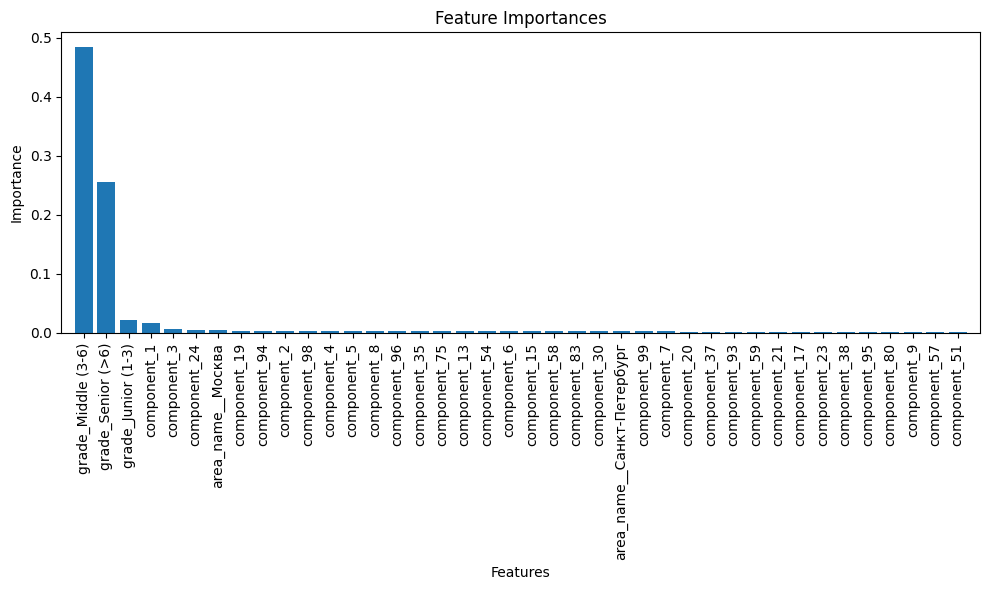

26195.181541959188


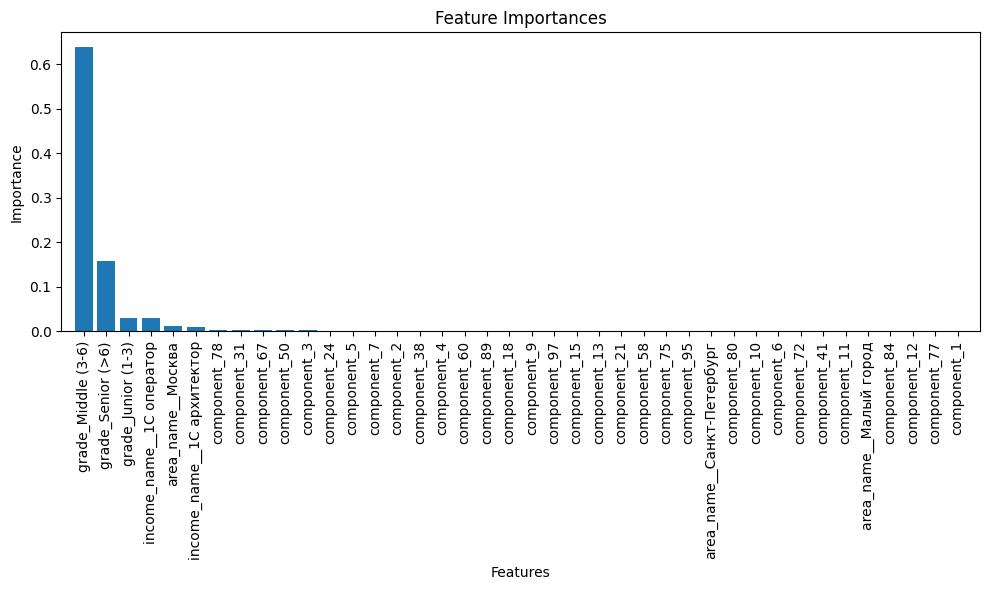

25787.62278948415


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (40,) and arg 1 with shape (16,).

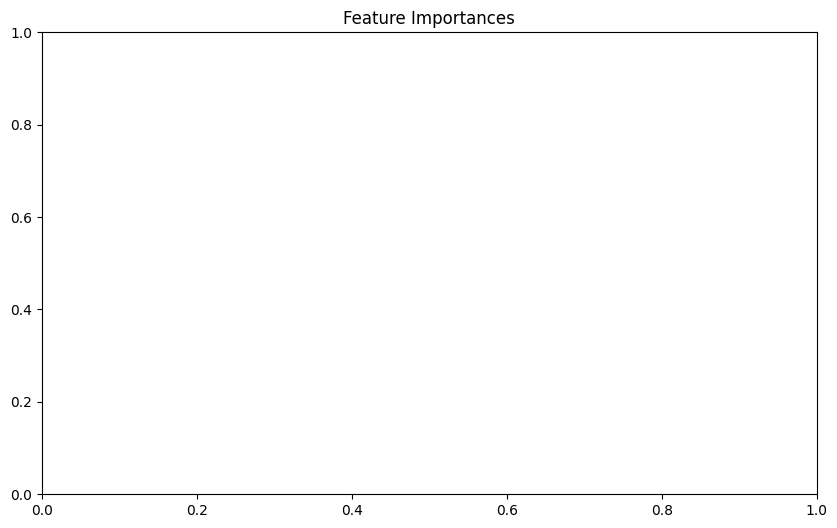

In [88]:
pretrained_model_IT = train(df_after_preprocess_IT, RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE))
pretrained_model_1C = train(df_after_preprocess_1C, RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE))
pretrained_model_other = train(df_after_preprocess_other, RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE))

# Test Prediction

In [89]:
def predict_random_from_category(model, data, num_samples = 3, category = None):

    if category == None:
        category = input('>>> Provide category for testing: ')

    for x in range(num_samples):

        random_cat_row = data[data[category] == 1].sample()

        true_salary = random_cat_row['salary_average'].item()
        true_low = random_cat_row['salary_from_gross'].item()
        true_high = random_cat_row['salary_to_gross'].item()

        X_sample = random_cat_row.drop(columns=['salary_from_gross', 'salary_to_gross', 'salary_average'])

        predicted_salary = model.predict(X_sample)[0]
        predicted_low = predicted_salary * 8 / 9
        predicted_low = int(np.round(predicted_low, -2))
        predicted_high = predicted_salary * 10 / 9
        predicted_high = int(np.round(predicted_high, -2))

        print(f"Истинная зарплата для случайной вакансии {x} в категории {category}:\n{true_low} -- {true_high}, среднее {true_salary}\n")
        print(f"Предсказанная зарплата:\n{predicted_low} -- {predicted_high}, среднее {predicted_salary}\n")
        print("____________________________________________________________________________________________\n")

In [ ]:
# predict_random_from_category(pretrained_model, df_after_preprocess, category = 'grade_Middle (3-6)')    

Истинная зарплата для случайной вакансии 0 в категории grade_Middle (3-6):
250000.0 -- 350000.0, среднее 300000.0

Предсказанная зарплата:
256400 -- 320500, среднее 288471.90476190473

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 1 в категории grade_Middle (3-6):
299288.57142857136 -- 349169.9999999999, среднее 324229.2857142856

Предсказанная зарплата:
214500 -- 268100, среднее 241275.34475595236

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 2 в категории grade_Middle (3-6):
250000.0 -- 300000.0, среднее 275000.0

Предсказанная зарплата:
233900 -- 292300, среднее 263084.02890476194

____________________________________________________________________________________________



In [ ]:
# predict_random_from_category(pretrained_model, df_after_preprocess, category = 'grade_Junior (1-3)')

Истинная зарплата для случайной вакансии 0 в категории grade_Junior (1-3):
67800.0 -- 79099.99999999999, среднее 73450.0

Предсказанная зарплата:
63900 -- 79800, среднее 71834.94218253967

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 1 в категории grade_Junior (1-3):
51979.99999999999 -- 60643.333333333314, среднее 56311.66666666666

Предсказанная зарплата:
77700 -- 97100, среднее 87405.10907142855

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 2 в категории grade_Junior (1-3):
56900.0 -- 66383.33333333331, среднее 61641.66666666666

Предсказанная зарплата:
63500 -- 79300, среднее 71392.04638769849

____________________________________________________________________________________________



In [ ]:
# predict_random_from_category(pretrained_model, df_after_preprocess, category = 'grade_Senior (>6)')

Истинная зарплата для случайной вакансии 0 в категории grade_Senior (>6):
282500.0 -- 329583.33333333326, среднее 306041.6666666666

Предсказанная зарплата:
257400 -- 321800, среднее 289625.69904761924

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 1 в категории grade_Senior (>6):
226000.0 -- 282500.0, среднее 254250.0

Предсказанная зарплата:
246400 -- 308000, среднее 277186.63820714294

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 2 в категории grade_Senior (>6):
521890.4999999999 -- 608872.2499999998, среднее 565381.3749999998

Предсказанная зарплата:
440100 -- 550100, среднее 495118.5112440476

____________________________________________________________________________________________

